### Gauss-Hermite integration for Aguirregabria model

We begin by integrating the custom Gauss-Hermite integration step into the standard "serial" code:

In [1]:
using Plots; pyplot()
using FastGaussQuadrature
include("../julia/aguirregabiria_core.jl")

compute_fixed_point (generic function with 1 method)

In [2]:
dmd_tf(x,y,z) = 1/sqrt(2*pi*sigma_eps^2)*exp.(-(x-(alpha+betas_transition.*log(y))).^2./(2*sigma_eps^2))

dmd_tf (generic function with 1 method)

In [3]:
@time dmd_transition_fs(1, 2, 1)

  0.162142 seconds (104.15 k allocations: 6.029 MiB)


3-element Array{Float64,1}:
 1.67834e-7
 0.0496474 
 0.199988  

In [4]:
@time dmd_tf(1, 2, 1)

  2.973709 seconds (978.88 k allocations: 51.580 MiB, 0.73% gc time)


3-element Array{Float64,1}:
 1.67834e-7
 0.0496474 
 0.199988  

In [19]:
lambdas      = generate_simplex_3dims(20)
n_price_grid = 20
min_price    = 0.5
max_price    = 1.5
price_grid   = linspace(min_price, max_price, n_price_grid)

function V_0(x) 
    optimal_price = myopic_price(x)
    return period_return(optimal_price, x)
end

V_0 (generic function with 1 method)

In [2]:
function rescale_demand(d, beta_l, price)
    # Rescales demand to use Gauss-Hermite 
    # collocation points.
    mu = alpha + beta_l*log.(price)
    
    return (sqrt(2)*sigma_eps*d + mu)
end

function adv_bellman_operator(Vguess, price_grid, lambda_simplex)
    
    policy = zeros(size(lambda_simplex, 1))
    T_V    = zeros(size(lambda_simplex, 1))

    # 1. Go over grid of state space
    # 2. Write objective (present return + delta*eOfV)
    # 3. Find optimal p on that objective
    # 4. Write optimal p and value function on that point in the grid
    
    GHx, GHw = gausshermite(25)
    
    @inbounds for index in 1:size(lambda_simplex, 1)
        
        lw = lambda_simplex[index, :]
        
        # Compute period returns
        R = period_return(price_grid, lw)
        
        # Compute the expectation integral of V0
        E0fV_p = zeros(price_grid)
        
        @inbounds for (i, price) in enumerate(price_grid)
            # Gauss-Hermite integration using pre-computed
            # collocations and weights.
            sum_over_each_lambda = 0.0
            @inbounds for (l, beta_l) in enumerate(betas_transition)
                @inbounds for (k, hermite_point) in enumerate(GHx)
                    rescaled_remand = rescale_demand(hermite_point, beta_l, price)
                    new_lw          = update_lambdas(rescaled_remand, price, ~, lw)
                    #v_value = f(new_lambdas_val)
                    sum_over_each_lambda += Vguess(new_lw)*GHw[k]*lw[l]
                end
            end
            E0fV_p[i] = (1/sqrt(pi) * sum_over_each_lambda)
        end
        
        #println(E0fV_p)
            
        # Maximize value function
        objective_vals = R + (delta *  E0fV_p)
            
        T_V[index], ind_max = findmax(objective_vals)                       
        policy[index] = price_grid[ind_max]

    end

    # Interpolate
    interp_T_V = interpV(lambda_simplex, T_V)

    return interp_T_V, policy
    
end

adv_bellman_operator (generic function with 1 method)

In [6]:
@time res_1 = adv_bellman_operator(V_0, price_grid, lambdas)

  1.226067 seconds (2.96 M allocations: 96.181 MiB)


(interpolate_V, [1.5, 1.5, 1.5, 1.39474, 1.23684, 1.5, 1.5, 0.763158, 0.763158, 0.657895, 0.710526, 0.710526, 0.657895, 0.657895, 0.657895])

In [7]:
@time res_2 = bellman_operator(V_0, price_grid, lambdas)

  4.353833 seconds (8.43 M allocations: 274.194 MiB, 14.12% gc time)


(interpolate_V, [1.5, 1.5, 1.5, 1.39474, 1.23684, 1.5, 1.5, 0.763158, 0.763158, 0.657895, 0.710526, 0.710526, 0.657895, 0.657895, 0.657895])

In [8]:
# Are results (2nd element, vector) identical?
res_1 .== res_2

(false, true)

In [9]:
function adv_compute_fixed_point(V, price_grid, lambda_simplex; error_tol=1e-5, max_iter=50, verbose=true, skip=10)

    iterate = 1
    error = error_tol + 1
    
    policy = similar(price_grid)
    error  = Inf

    while iterate <= max_iter && error > error_tol
        if verbose && (mod(iterate, skip) == 0)
            tic()
        end

        new_V, policy = adv_bellman_operator(V, price_grid, lambda_simplex)
                        
        # Compute error over simplex:
        error = 0
        for i in 1:size(lambda_simplex,1)
            error += abs(V(lambda_simplex[i,:])-new_V(lambda_simplex[i,:]))
        end

        V = new_V

        if verbose && (mod(iterate, skip) == 0)
            println(@sprintf("Computed iterate %d with error %.4f", iterate, error))
            print(" !-- ")
            toc()
        end
                        
        iterate += 1                
                        
    end

    return V, policy, error

end

adv_compute_fixed_point (generic function with 1 method)

In [20]:
include("../julia/aguirregabiria_core.jl")
@time V, policy, error = adv_compute_fixed_point(V_0, price_grid, lambdas,  max_iter=100, skip=10)

Computed iterate 10 with error 147.4371
 !-- elapsed time: 5.002860282 seconds
Computed iterate 20 with error 51.4414
 !-- elapsed time: 5.048032854 seconds
Computed iterate 30 with error 17.9409
 !-- elapsed time: 5.092238137 seconds
Computed iterate 40 with error 6.2569
 !-- elapsed time: 5.039104736 seconds
Computed iterate 50 with error 2.1820
 !-- elapsed time: 5.059191516 seconds
Computed iterate 60 with error 0.7609
 !-- elapsed time: 4.649542063 seconds
Computed iterate 70 with error 0.2653
 !-- elapsed time: 4.468988413 seconds
Computed iterate 80 with error 0.0925
 !-- elapsed time: 4.515979986 seconds
Computed iterate 90 with error 0.0323
 !-- elapsed time: 4.544097807 seconds
Computed iterate 100 with error 0.0113
 !-- elapsed time: 4.53168291 seconds
491.241999 seconds (2.80 G allocations: 80.757 GiB, 5.90% gc time)


(interpolate_V, [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5  …  0.657895, 0.657895, 0.657895, 0.657895, 0.657895, 0.657895, 0.657895, 0.657895, 0.657895, 0.657895], 0.01125072208685296)

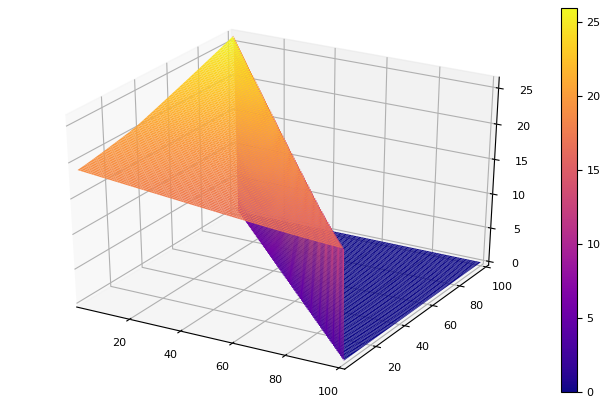

In [21]:
X = linspace(0, 1, 100)
Y = linspace(0, 1, 100)

Vplot = zeros(length(X), length(Y))

for (i, x) in enumerate(X)
    for j in 1:(length(X)-i+1)
        Vplot[i, j] = V([x, Y[j], 1-(x+Y[j])])
    end
end

surface(Vplot, color = :plasma)

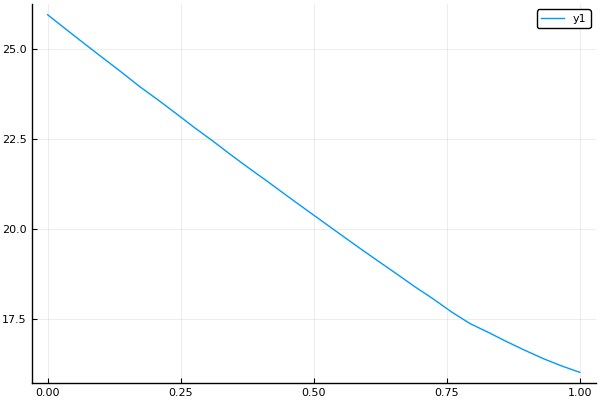

In [22]:
lambdas_selected = [[i, 0.9*(1-i), 0.1*(1-i)] for i in linspace(1, 0, 30)]

valuef_values = V.(lambdas_selected)
plot(linspace(0., 1., 30), valuef_values)

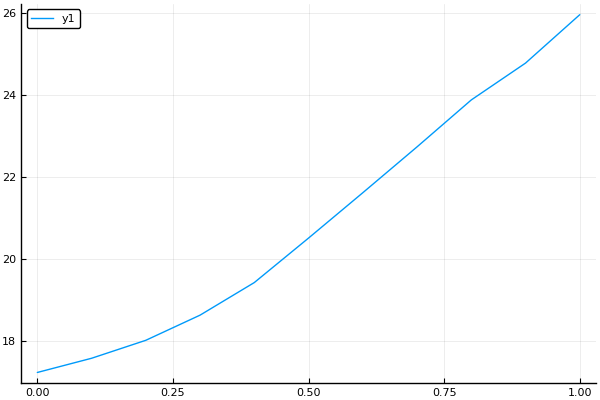

In [23]:
lambdas_selected = [[0.0, 0.5, 0.5],
                    [0.1, 0.5, 0.4],
                    [0.2, 0.5, 0.3],
                    [0.3, 0.5, 0.2],
                    [0.4, 0.5, 0.1],
                    [0.5, 0.4, 0.1],
                    [0.6, 0.3, 0.1],
                    [0.7, 0.2, 0.1],
                    [0.8, 0.1, 0.1],
                    [0.9, 0.1, 0.0],
                    [1.0, 0.0, 0.0]]

valuef_values = V.(lambdas_selected)
plot(0:0.1:1, valuef_values)

In [14]:
# Too long...
#@time compute_fixed_point(V_0, price_grid, lambdas, skip=5)

#### Manual interpolation

Test direct linear interpolation over triangular lattice:

In [15]:
function tripolate(V, x, y)
    # Triangular (linear) interpolation:
    # 0<=|x|<=1, 0<=|y|<=1 and N parition points
    # of [0,1] for x, y
    N  = size(V, 1)-1
    xf = Int(floor(N*x) - floor(x))
    yf = Int(floor(N*y) - floor(y))
    x_ = (N*x - xf)
    y_ = (N*y - yf)
    if min(xf, yf) == 0 && max(xf, yf) <= 1
        x_ = 1-x_
        y_ = 1-y_
    end
    if xf + yf <= 1
        return V[xf+2,yf+1]*(1-x_) + V[xf+1,yf+2]*(1-y_) - V[xf+1,yf+1]*(1-x_-y_)
    else
        return V[xf+2,yf+1]*(x_) + V[xf+1,yf+2]*(y_) + V[xf+1,yf+1]*(1-x_-y_)
    end 
end


tripolate (generic function with 1 method)

In [18]:
V = [1 0.5 0; 0.5 0 0; 0 0 0;]

@time tripolate(V, 0.3, 0.3)

  0.000003 seconds (5 allocations: 176 bytes)


0.4

In [17]:
simplex = [0.0 0.0; 0.0 0.5;]

@time begin 
    f = interpV(simplex, V)
    f([0.3, 0.3, 0.0])
end

LoadError: [91mBoundsError: attempt to access 3×3 Array{Float64,2} at index [10][39m